## Extractive Summerization

In [1]:
# import libraries
from collections import Counter
from itertools import combinations
from math import sqrt
import matplotlib.pyplot as plt
import networkx as nx
from nltk import word_tokenize, sent_tokenize, FreqDist,pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import RegexpTokenizer
from operator import itemgetter
import re
%matplotlib inline

In [2]:
# Convergence threshold is the maximum error in score convergence of TextRank
CONVERGENCE_THRESHOLD = 0.0001

In [3]:
# set of all nouns
NOUNS = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}

In [4]:
class Document():
    '''
    The master class for our Document Summerization module.
    Incorporates all features related to Document
    '''
    
    def __init__(self, document):
        self.document = document
        self.sents = sent_tokenize(self.document)
        self.word_freq = FreqDist(clean(self.document))
        self.graph = None
        self.params = { 'thresh': 0.0
            
        }
        
                
    def __str__(self):
        return self.document
    
    
    def statistical_sim(self, sent1, sent2):
        '''
        Statistical similarity between sentences
        based on the cosine method
        Returns: float (the cosine similarity b/w sent1 and sent2)
        '''
        sent_token1 = Counter(sent1)
        sent_token2 = Counter(sent2)
        
        intxn = set(sent_token1) & set(sent_token2)
        numerator = sum([sent_token1[x] * sent_token2[x] for x in intxn])
        
        mod1 = sum([sent_token1[x]**2 for x in sent_token1.keys()])
        mod2 = sum([sent_token2[x]**2 for x in sent_token2.keys()])
        denominator = sqrt(mod1)*sqrt(mod2)
        
        if not denominator:
            return 0.0

        return float(numerator)/denominator
    
    
    def semantic_sim(self, sent1, sent2):
        '''
        A semantic similarity score between two sentences
        based on WordNet
        Returns: float (the semantic similarity measure)
        '''
        score = 0
        sent1 = [word for word in sent1 if word in NOUNS]
        sent2 = [word for word in sent2 if word in NOUNS]
        for t1 in sent1:
            for t2 in sent2:
                score += semantic_score(t1,t2)
        return score/(len(sent1 + sent2))  
    
    
    def construct_graph(self):
        '''
        Constructs the word similarity graph
        '''
        connected = []
        for pair in combinations(self.sents, 2):
            cpair = clean(pair[0]), clean(pair[1])
            weight = self.statistical_sim(*cpair) + \
                     self.semantic_sim(*cpair)
            connected.append((pair[0], pair[1], weight))
        self.graph = draw_graph(connected, self.params['thresh'])    

In [5]:
# Utility functions
def clean(sent):
    '''
    A utility function that returns a a list of words in a sentence
    after cleaning it. Gets rid off uppper-case, punctuations, 
    stop words, etc.
    Returns: list (a list of cleaned words in sentence)
    '''
    words =  sent.lower() 
    words = re.findall(r'\w+', words,flags = re.UNICODE | re.LOCALE) 
    imp_words = filter(lambda x: x not in stopwords.words('english'), words)
    return imp_words
        
def semantic_score(word1, word2):
    '''
    Semantic score between two words based on WordNet
    Returns: float (the semantic score between word1 and word2)
    '''
    try:
        w1 = wn.synset('%s.n.01'%(word1))
        w2 = wn.synset('%s.n.01'%(word2))
        return wn.path_similarity(w1,w2,simulate_root = False)
    except:
        return 0
    
def draw_graph(connected, thresh):
    '''
    Draws graph as per weights and puts edges if 
    weight exceed the given thresh
    Returns: networkx Graph (nodes are sentences and edges
             are statistical and semantic relationships)
    '''
    nodes = set([n1 for n1, n2, n3 in connected] + \
                [n2 for n1, n2, n3 in connected])
    G=nx.Graph()
    for node in nodes:
        G.add_node(node)
    for edge in connected:
        if edge[2] > thresh:
            G.add_edge(edge[0], edge[1],weight = edge[2])
    plt.figure(figsize=(8,8))
    pos = nx.spring_layout(G)
    nx.draw(G,node_color='#A0CBE2', edge_color='orange',width=1,with_labels=False)
    plt.show()
    return G
    
def textrank_weighted(graph, initial_value=None, damping=0.85):
    '''
    Calculates PageRank for an undirected graph
    Returns: A list of tuples representing sentences and respective
    scores in descending order
    '''
    if initial_value == None: initial_value = 1.0 / len(graph.nodes())
    scores = dict.fromkeys(graph.nodes(), initial_value)

    iteration_quantity = 0
    for iteration_number in xrange(100):
        iteration_quantity += 1
        convergence_achieved = 0
        for i in graph.nodes():
            rank = 1 - damping
            for j in graph.neighbors(i):
                neighbors_sum = sum([graph.get_edge_data(j, k)['weight'] for k in graph.neighbors(j)])
                rank += damping * scores[j] * graph.get_edge_data(j, i)['weight'] / neighbors_sum

            if abs(scores[i] - rank) <= CONVERGENCE_THRESHOLD:
                convergence_achieved += 1

            scores[i] = rank

        if convergence_achieved == len(graph.nodes()):
            break
    return sorted(scores.items(), key=itemgetter(1), reverse=True)

In [6]:
s = '''
burning tires tear gas and clashes with riot police the ugly scenes that come with workers strikes are all too familiar in france a country constantly trying to balance its culture of workers rights with a more efficient economy.
such scenes are being played out across the country friday as unions have called for workers to step up protests that have for the past week crippled parts of france.
employees of oil refineries nuclear power plants and some public transportation have left one in three gas stations dry forcing vehicles to search for well stocked stations and causing long lines at the pump.
people are now hoarding gas worried that it may be some time until supply levels are back to normal.
the workers are protesting a labor reform bill put forward by the government that will make it easier for companies to hire and fire employees.
the governments argument is that the strict laws that make french workers among the best protected in the world leave companies in a difficult position where they cant take on new staff.
french prime minister manuel valls told local media on thursday that he might be willing to modify some of the proposals giving hope to french people that the protests and fuel shortages may soon stop.
but workers unions friday responded with a call to step up rallies and blockades demanding a complete withdrawal of the bill.
we call for the continuation and intensification of protests a group of unions behind the protests said in a statement.
the governments violent words its contempt for the social movement and its refusal to withdraw this bill reinforces our commitment it said.
'''

In [7]:
a = Document(s)

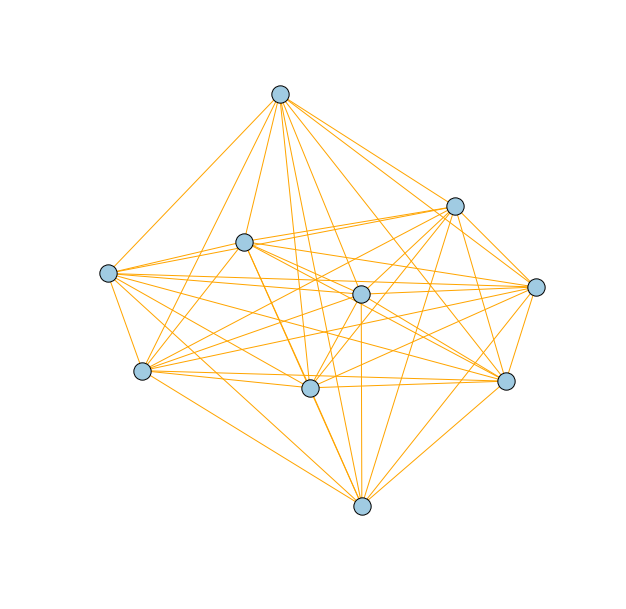

In [8]:
a.construct_graph()

In [9]:
x = textrank_weighted(a.graph)
for sent, score in x:
    print sent + '\n' + str(score) + '\n'


burning tires tear gas and clashes with riot police the ugly scenes that come with workers strikes are all too familiar in france a country constantly trying to balance its culture of workers rights with a more efficient economy.
1.14087625641

french prime minister manuel valls told local media on thursday that he might be willing to modify some of the proposals giving hope to french people that the protests and fuel shortages may soon stop.
1.12381553352

employees of oil refineries nuclear power plants and some public transportation have left one in three gas stations dry forcing vehicles to search for well stocked stations and causing long lines at the pump.
1.09261682598

such scenes are being played out across the country friday as unions have called for workers to step up protests that have for the past week crippled parts of france.
1.05530123576

the governments argument is that the strict laws that make french workers among the best protected in the world leave companies in 